In [38]:
import proposal as pp
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from helper_functions_multi import get_angle_deviation

In [2]:
momentum = 168.9 # MeV/c , 172
m = 105.7 # MeV
E = np.sqrt(momentum**2 + m**2)


E_i = momentum # 1e9 # 1 PeV 
E_f = 1e1 # 1e5 # 100 GeV
n_events = 10000 # 2500
    
deflection = [
    'bremsginneken', 
    'ioniznaive',
    'photoginneken',
    'epairginneken'] ### same as default
    
e_cut = np.inf # 1e10
v_cut = 0.001 # 1e-5
cont_rand = False
scattering_method = "moliere" # "highland"
deflection_type = "m_scat+stochastic"
  
# table_path = "/Users/pascalgutjahr/.cache/PROPOSAL" # macbook pro
table_path = "/net/nfshome/home/pgutjahr/.cache/PROPOSAL" # vollmond
    
rnd_seed = 71530

interpol_nodes = 200

initial_direction = [0, 0, 1]

beta_brems = 1.0
beta_ioniz = 1.0
beta_epair = 1.0
beta_multiplescatter = 1.0
beta_photonuclear = 1.0

max_dist = 10.9 # in cm = 109 mm

In [3]:
pp.InterpolationSettings.tables_path = table_path   # version 7
    
pp.InterpolationSettings.nodes_dndx_e = interpol_nodes
pp.InterpolationSettings.nodes_dndx_v = interpol_nodes

pp.RandomGenerator.get().set_seed(rnd_seed)
args = {
        "particle_def": pp.particle.MuMinusDef(),
        "target": pp.medium.Hydrogen(),
        "interpolate": True,
        "cuts": pp.EnergyCutSettings(e_cut, v_cut, cont_rand)
        }

cross = pp.crosssection.make_std_crosssection(**args)
multiple_scatter = pp.make_multiple_scattering(scattering_method, args["particle_def"], args["target"], cross, True)

stochastic_deflect = []
for d in deflection:
    stochastic_deflect.append(pp.make_stochastic_deflection(d, 
    args["particle_def"], args["target"]))


collection = pp.PropagationUtilityCollection()
collection.displacement = pp.make_displacement(cross, True)
collection.interaction = pp.make_interaction(cross, True)
collection.time = pp.make_time(cross, args["particle_def"], True)
collection.decay = pp.make_decay(cross, args["particle_def"], True)



collection.scattering = pp.scattering.ScatteringMultiplier(
    multiple_scatter, 
    stochastic_deflect, 
    beta_multiplescatter, 
    [(pp.particle.Interaction_Type.brems, beta_brems), (pp.particle.Interaction_Type.ioniz, beta_ioniz), 
    (pp.particle.Interaction_Type.epair, beta_epair), (pp.particle.Interaction_Type.photonuclear, beta_photonuclear)])


utility = pp.PropagationUtility(collection = collection)
detector = pp.geometry.Sphere(pp.Cartesian3D(0,0,0), 1e20) # version 7
density_distr = pp.density_distribution.density_homogeneous(args["target"].mass_density)


prop = pp.Propagator(args["particle_def"], [(detector, utility, density_distr)])

init_state = pp.particle.ParticleState()
init_state.position = pp.Cartesian3D(0, 0, 0) # version 7
init_state.direction = pp.Cartesian3D(initial_direction[0], initial_direction[1], initial_direction[2]) # version 7

In [4]:
tracks = []
for i in tqdm(range(n_events)):
    init_state.energy = E_i # initial energy in MeV
    track = prop.propagate(init_state, max_distance = max_dist, min_energy = E_f) # max_dist=1e9
    tracks.append(track)

100%|██████████| 10000/10000 [00:00<00:00, 13038.88it/s]


In [5]:
tracks_109 = []
for track in tracks:
    if track.track_propagated_distances()[-1] == 10.9:
        tracks_109.append(track)

In [6]:
len(tracks_109)

9846

In [16]:
print(track.track_directions()[-1])

=================== Vector3D (0x47197c0) ===================
x: 0.0106193	y: -0.0128231	z: 0.999861


In [45]:
print(pp.Spherical3D(track.track_directions()[1]))

=================== Vector3D (0x4bd73a0) ===================
radius: 1	azimuth: -0.879131	zenith: 0.0166502


In [9]:

track.track_directions()[1].spherical_coordinates

[1.0, -0.8791310141186945, 0.016650191975939737]

In [19]:
tracks_109_zenith = []
tracks_109_azimuth = []
tracks_109_x = []
tracks_109_y = []
tracks_109_z = []
for track in tracks_109:
    tracks_109_zenith.append(track.track_directions()[-1].spherical_coordinates[2])
    tracks_109_azimuth.append(track.track_directions()[-1].spherical_coordinates[1])
    tracks_109_x.append(track.track_directions()[-1].x)
    tracks_109_y.append(track.track_directions()[-1].y)
    tracks_109_z.append(track.track_directions()[-1].z)

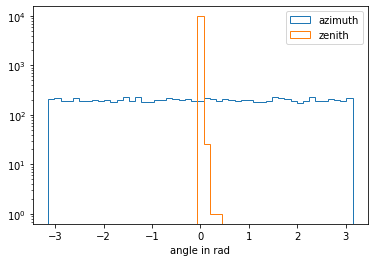

In [20]:
bins = np.linspace(-np.pi, np.pi, 50)
plt.hist(tracks_109_azimuth, bins=bins, histtype='step', label='azimuth')
plt.hist(tracks_109_zenith, bins=bins, histtype='step', label='zenith')
plt.xlabel('angle in rad')
plt.yscale('log')
plt.legend()

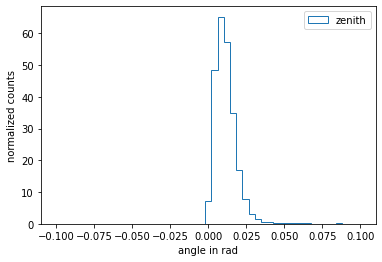

In [21]:
bins = np.linspace(-0.1, 0.1, 50)
plt.hist(tracks_109_zenith, bins=bins, histtype='step', density=True, label='zenith')
plt.ylabel('normalized counts')
plt.xlabel('angle in rad')
plt.legend()

In [31]:
def projection(y, z):
    if not isinstance(y, np.ndarray):
        y = np.array(y)
    if not isinstance(z, np.ndarray):
        z = np.array(z)
    return np.tan(y / z)

In [32]:
projection(tracks_109_y, tracks_109_z)

array([-0.00072148,  0.01330111, -0.01099777, ...,  0.01035809,
        0.00697737, -0.01282562])

In [47]:
angles = get_angle_deviation(0, 0, np.array(tracks_109_azimuth), np.array(tracks_109_zenith))
angles

array([0.01644556, 0.01546471, 0.01217058, ..., 0.0155244 , 0.00718501,
       0.01665019], dtype=float128)

/home/pgutjahr/proposal_7_3_0/lib64/python3.6/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


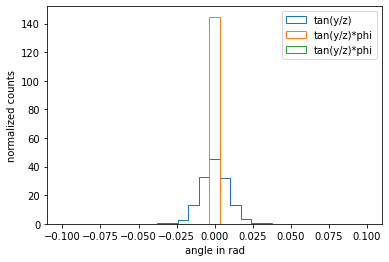

In [49]:
bins = np.linspace(-0.1, 0.1, 30)
plt.hist(projection(tracks_109_y, tracks_109_z), bins=bins, histtype='step', density=True, label='tan(y/z)')
plt.hist(projection(tracks_109_y, tracks_109_z) * angles, bins=bins, histtype='step', density=True, label='tan(y/z)*phi')
plt.hist(angles/projection(tracks_109_y, tracks_109_z), bins=bins, histtype='step', density=True, label='tan(y/z)*phi')
plt.ylabel('normalized counts')
plt.xlabel('angle in rad')
plt.legend()

In [43]:
print(track.track_directions()[0])

=================== Vector3D (0x5129700) ===================
x: 0	y: 0	z: 1


In [50]:
reproduziere den plot von attwood -> irgendwie muss der winkel noch berücksichtigt werden, wie?
lese schon mal die daten von attwood ein und erzeuge dann einen auf 100% normierten bar plot

SyntaxError: invalid syntax (<ipython-input-50-9302cf18156a>, line 2)